In [2]:
from sklearn.model_selection import GridSearchCV
import gensim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
import embeddingvectorizer
import json
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.multiclass import OneVsRestClassifier 
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier 

from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier

from sklearn.model_selection import cross_val_score
from collections import defaultdict
from tabulate import tabulate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

from nltk.corpus import stopwords
from string import punctuation
import nltk
import pandas as pd
from collections import Counter
from nltk.stem.snowball import SnowballStemmer


In [5]:
OUTPUT_PATH ='../output/'
PATH = '/Users/anne/surfdrive/uva/projects/RPA_KeepingScore/data/RPA_data_with_dictionaryscores.pkl'
PE = '/Users/anne/repos/embedding_models/RPA/w2v_300d2000-01-01_2018-12-31'

In [ ]:
print("\nLoading model")
mod = gensim.models.Word2Vec.load(PE)
MDL = dict(zip(mod.wv.index2word, mod.wv.syn0))

In [6]:
df = pd.read_pickle(PATH)

In [7]:
# only keep newspaper data
df = df[df['type'] == 'newspaper']
# define frames
frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']

# 2 = not present, set to zero (0 = not present, 1 = present)
df[frames] = df[frames].replace({2:0})
df['attrresp'].fillna(0, inplace=True)
df.rename(columns= {'text_x': 'text'}, inplace=True)

Text(0.5, 0, 'category')

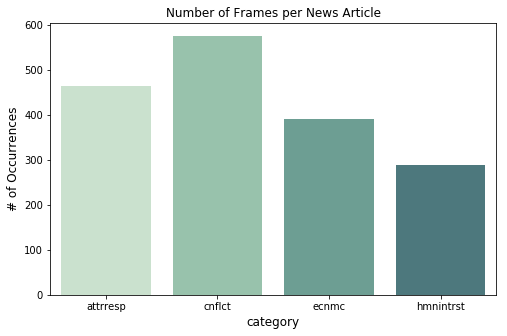

In [9]:
df_ = df[frames]
counts = []
categories = list(df_.columns.values)
for i in categories:
    counts.append((i, df_[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

plt.figure(figsize=(8,5))
ax = sns.barplot(x='category', y='number_of_comments', data=df_stats, palette=sns.cubehelix_palette(rot=-.4))
plt.title("Number of Frames per News Article")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

Text(0.5, 0, '# of frames')

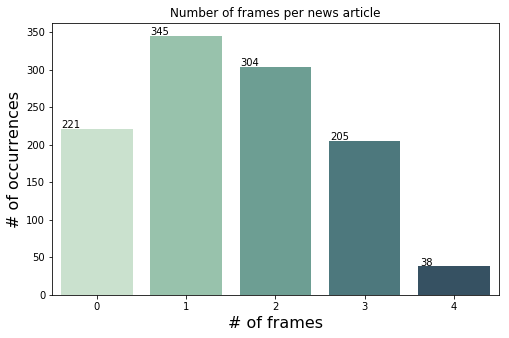

In [19]:
rowsums = df_[frames].sum(axis=1).astype(int)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values, palette=sns.cubehelix_palette(rot=-.4))
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
    
plt.title("Number of frames per news article")
plt.ylabel('# of occurrences', fontsize=16)
plt.xlabel('# of frames', fontsize=16)

In [ ]:
train, test = train_test_split(df, random_state=42, test_size=0.3, shuffle=True)

x_train = train.text
x_test = test.text

In [ ]:
list(train.columns)

In [ ]:
## clean att
mystopwords = stopwords.words('dutch')
extra_stop = [line.strip() for line in open('../stopwords/stopwords_NL.txt').readlines() if len(line)>1]
mystopwords = set(mystopwords + extra_stop)

def get_dictionaries(frame):
    att = " ".join(train[frame].dropna().to_list())
    body_of_text="".join([l for l in att.lower() if l not in punctuation])  
    body_of_text=" ".join(body_of_text.split())
    text_clean = " ".join([w for w in body_of_text.split() if w not in mystopwords and len(w) > 1]) 
    attribution_clean = " ".join([w for w in text_clean.split() if w.isalpha()]) 
    att = set(attribution_clean.split())
    return attribution_clean, att

In [ ]:
print("Some info on the dictionaries:\n\n")
print("The dictionary Attribution of Responsibility contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('attrresp_wrds')[1]), Counter(get_dictionaries('attrresp_wrds')[0].split()).most_common(5)))
print("The dictionary Human Interst contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('hmnintrst_wrds')[1]), Counter(get_dictionaries('hmnintrst_wrds')[0].split()).most_common(5)))
print("The dictionary Economic Consequences contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('ecnmc_wrds')[1]), Counter(get_dictionaries('ecnmc_wrds')[0].split()).most_common(5)))
print("The dictionary Conflict contains {} words. These are the most common words:\n\n{}\n\n".format(len(get_dictionaries('cnflct_wrds')[1]), Counter(get_dictionaries('cnflct_wrds')[0].split()).most_common(5)))

In [ ]:
def get_final_dicts():
    frame_dict = defaultdict()
    frame_dict['att_d'] = [i[0] for i in Counter(get_dictionaries('attrresp_wrds')[0].split()).most_common(50)]
    frame_dict['hmninstr_d'] = [i[0] for i in Counter(get_dictionaries('hmnintrst_wrds')[0].split()).most_common(50)]
    frame_dict['cnflct_d'] = [i[0] for i in Counter(get_dictionaries('cnflct_wrds')[0].split()).most_common(50)]
    frame_dict['ecnm_d'] = [i[0] for i in Counter(get_dictionaries('ecnmc_wrds')[0].split()).most_common(50)]
    return frame_dict

In [ ]:
def get_stemmed_dict():
    stemmer = SnowballStemmer("dutch")
    d = get_final_dicts()
    stemmed_dictionary = {}
    for frame, words in d.items():
        stemmed_dictionary[frame] = [ stemmer.stem(w) for w in words ]
    return stemmed_dictionary

get_stemmed_dict()

In [ ]:
def map_dict_to_text(type_of_text, stemmed):
    result = []
    for document, documentnr in zip(test[type_of_text], test['documentnr']):
        topics_per_document = {}
        document = str(document)
        if stemmed == False:
            d = get_final_dicts()
        elif stemmed == True:
            d = get_stemmed_dict()
        for topic, words in d.items():
            try:
                match = [x for x in words if x in document.lower().split(' ')]
            except:
                print("HU", document)
                match = []

            topics_per_document = {'documentnr' : documentnr,
                                    'frame': topic,
                                    'len matches' : len(match),
                                    'words matches' : match }
            result.append(topics_per_document)
    df2 = pd.DataFrame.from_dict(result)
    df3 = df2.pivot(index='documentnr', columns='frame', values='len matches')
    df3[df3>1] = 1
    return df3

In [ ]:
#test['stemmed_text']

In [ ]:
#df3 = df2.pivot(index='documentnr', columns='frame', values='len matches')
#df3[df3>1] = 1

#df1 = get_tp_fp_fn(type_of_text = 'text', stemmed = False)
#df2 = map_dict_to_text(type_of_text = 'stemmed_text', stemmed = True)

In [ ]:
#df1[['cnflct_d', 'cnflct', '_tp cnflct', '_fn cnflct', '_fp cnflct']]

#df1.columns

In [ ]:
def get_tp_fp_fn(type_of_text, stemmed):

    '''create columns with true postives, false positives, and false negatives'''
  #  df = pd.merge(test, df3, how= 'left', on = 'documentnr')
    df3 = map_dict_to_text(type_of_text = type_of_text, stemmed = stemmed)
    df = pd.merge(test, df3, how= 'left', on = 'documentnr')
    frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']
    frames_d = ['att_d' , 'cnflct_d', 'ecnm_d','hmninstr_d']

    
    for frame, frame_d in zip(frames, frames_d):
        columnname_tp = "_tp " + str(frame)
        columnname_fp = "_fp " + str(frame)
        columnname_fn = "_fn " + str(frame)
        
        df[columnname_tp] = np.where( (df[frame] == 1) & (df[frame_d] == 1) , 1, 0 )
            # false positive = dictionary identified, but golden standard not.
        df[columnname_fp] = np.where( (df[frame] != 1) & (df[frame_d] == 1) , 1, 0 )
        # false negative = dictionary NOT identified, but golden standard DID identify
        df[columnname_fn] = np.where( (df[frame] == 2) & (df[frame_d] != 1) , 1, 0 )
        
    return df


In [ ]:
def get_recall_precision(frames, type_of_text, stemmed):

    true_positives = ["_tp " + str(i) for i in frames]
    false_positives = ["_fp " + str(i) for i in frames]
    false_negatives = ["_fn " + str(i) for i in frames]

    recall = {}
    precision = {}
    f1score = {}

    df = get_tp_fp_fn(type_of_text = type_of_text, stemmed=stemmed)
    
    for tp, fp, fn, frame in zip(true_positives, false_positives, false_negatives, frames) :

        recall[str(frame)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fn].sum(axis=0) )
        precision[str(frame)] = df[tp].sum(axis=0) / ( df[tp].sum(axis=0) + df[fp].sum(axis=0) )
        f1score[str(frame)] = 2 * ( ( precision[str(frame)] * recall[str(frame)] ) / ( precision[str(frame)] + recall[str(frame)] ) )
        
    recall['total'] = sum(recall.values()) / len(recall.values())
    precision['total'] = sum(precision.values()) / len(precision.values())
    f1score['total'] = sum(f1score.values()) / len(f1score.values())
    
    return recall, precision, f1score

In [ ]:
frames = ['attrresp', 'cnflct','ecnmc', 'hmnintrst']
recall, precision, f1score = get_recall_precision(frames = frames, type_of_text = 'stemmed_text', stemmed=True)
f1score

In [ ]:
recall, precision, f1score = get_recall_precision(frames = frames, type_of_text = 'text', stemmed=False)
total = { k: [ precision[k] , recall[k], f1score[k]] for k in recall }

In [ ]:
total

In [ ]:
for document in test['stemmed_text']:
        documentnr += 1
        topics_per_document = {}
        d = get_stemmed_dict()
        for topic, words in d.items():
            match = [x for x in words if x in document.lower().split(' ')]
            doc_string = document.lower().split(' ')
            index = [doc_string.index(word) for word in match ]
            try:
                index_smallest = min(index)
            except:
                index_smallest = np.nan

            topics_per_document = {'documentnr' : documentnr,
                                    'stemmed_topic_label_dictionary': topic,
                                    'stemmed_index_words' : index,
                                    'stemmed_smallest_index' : index_smallest,
                                    'stemmed_len matches' : len(match),
                                    'stemmed_words matches' : match  ,
                                    'stemmed_text' : document.lower()}
            result.append(topics_per_document)
        return result

In [ ]:
hmnintrst = [item for sublist in hmnintrst for item in sublist]
cnflct = [item for sublist in cnflct for item in sublist]
ecnm = [item for sublist in ecnm for item in sublist]

In [8]:
p = '/Users/anne/repos/RPA/output/frames/SML_results'

with open(p) as handle:
            dictdump = json.loads(handle.read()) 
            
df = pd.DataFrame.from_dict(dictdump)
df.sort_values(['frame','accuracy'], ascending=False).to_csv(OUTPUT_PATH + 'results_frames.csv')

,frame,class_name,accuracy,precision_micro,f1_micro,recall_macro,precision_macro,f1_macro,recall_micro
37,hmnintrst,SVC count,0.744557,0.744557,0.744557,0.531619,0.787040,0.488882,0.744557
43,hmnintrst,PA tfidf embedding,0.744524,0.744524,0.744524,0.594777,0.656055,0.593463,0.744524
39,hmnintrst,SVC tfidf embedding,0.743242,0.743242,0.743242,0.529005,0.751492,0.485233,0.743242
45,hmnintrst,ET count,0.739421,0.739421,0.739421,0.543089,0.668149,0.520815,0.739421
38,hmnintrst,SVC count embedding,0.739404,0.739404,0.739404,0.520359,0.754945,0.468171,0.739404
46,hmnintrst,ET count embedding,0.739380,0.739380,0.739380,0.576579,0.657090,0.577273,0.739380
47,hmnintrst,ET tifdf embedding,0.736832,0.736832,0.736832,0.568751,0.645359,0.566230,0.736832
40,hmnintrst,PA tfidf,0.736816,0.736816,0.736816,0.589978,0.649002,0.595561,0.736816
44,hmnintrst,ET tfidf,0.735558,0.735558,0.735558,0.529932,0.647831,0.495912,0.735558
41,hmnintrst,PA count,0.734301,0.734301,0.734301,0.599905,0.684728,0.591418,0.734301


In [20]:
import json
import logging
import pandas as pd

logger = logging.getLogger()
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s')
logging.root.setLevel(level=logging.INFO)

class plot_accuracy_precision_recall():
    '''This prepares a CNN model and runs it'''

    def __init__(self, path_to_data, path_to_output):
        self.path_to_data = path_to_data
        self.path_to_output = path_to_output
        self.translator = {'hmnintrst' : 'Human interest', 'ecnmc' : 'Economic consequences', 'cnflct' : 'Conflict', 
                           'attrresp' : 'Attribution of responsibility'}
  #      with open('../resources/numbers_to_topic.json') as handle:
   #            self.translator_numeric = json.loads(handle.read()) 
        
    def get_data_dictionary(self):
         # getting Dictionary Approach Data
        fname = '{}recision_recall_f1score_dictionary_stemmed_FRAMES.json'.format(self.path_to_data)
        logger.info(fname)
        
        with open(fname) as handle:
            dictdump =  json.loads(handle.read()) 
            
        df = pd.DataFrame.from_dict(dictdump).transpose()
        df['classifier'] = 'Dictionary - stemmed'

        fname_notstemmed = '{}recision_recall_f1score_dictionary_not_stemmed_FRAMES.json'.format(self.path_to_data)
        logger.info(fname_notstemmed)

        with open(fname_notstemmed) as handle:
            dictdump =  json.loads(handle.read()) 
            
        df2 = pd.DataFrame.from_dict(dictdump).transpose()
        df2['classifier'] = 'Dictionary - not stemmed'
        
        df = pd.concat([df, df2])
        df.rename(columns={0 :'precision',  1 :'recall', 2 :'f1-score', 3 : 'accuracy'}, inplace=True)
        df.rename(index=self.translator, inplace=True)
        df['approach'] = 'Dictionary Approach'
        return df
    
    def get_data_sml(self):
    
        fname_sml = '{}SML_results_text_cleaned'.format(self.path_to_data)
        with open(fname_sml) as handle:
            dictdump =  json.loads(handle.read()) 
        df = pd.DataFrame.from_dict(dictdump)
        df['frame'].replace(self.translator, inplace=True)
        df.set_index('frame', inplace=True)
      #  df[]'frame', inplace=True)
        df = df[['class_name','f1_micro', 'precision_micro', 'recall_micro', 'accuracy']]
        df.rename(columns={'class_name': 'classifier', 'f1_micro' : 'f1-score', 'precision_micro' : 'precision', 'recall_micro' : 'recall'}, inplace=True)
        df['approach'] = 'SML'
        return df
    
    def combine_datasets(self):
        df1 = self.get_data_dictionary()
        df2 = self.get_data_sml()
        df = pd.concat([df1, df2])
     #   df.drop('total', inplace=True)
        df['Frame'] = df.index
        return df

In [28]:
PATH = '../output/frames/'
OUTPUT_PATH ='../output/'

a = plot_accuracy_precision_recall(PATH, OUTPUT_PATH)
df = a.combine_datasets()
df.sort_values(['Frame','accuracy'], ascending=False).to_csv(OUTPUT_PATH + 'results_frames.csv')
#df['accuracy', 'recall'].sum()
#df = df.groupby(['classifier', 'Frame']).max()


2019-10-21 13:58:07,681 : INFO : ../output/frames/recision_recall_f1score_dictionary_stemmed_FRAMES.json
2019-10-21 13:58:07,687 : INFO : ../output/frames/recision_recall_f1score_dictionary_not_stemmed_FRAMES.json
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [ ]:
f, ax = plt.subplots(figsize=(10,14))
sns.set_context('talk')
sns.set(style="whitegrid")

ax = sns.barplot(x="accuracy", y="Frame", hue = "classifier", edgecolor=".7",  palette="ch:.25", data=df)
ax = sns.set_style("white")
plt.title(None)
plt.ylabel(None)
plt.xlabel(None)

In [ ]:
df[['accuracy', 'recall']].sum(axis=1).sum(axis=0)


In [ ]:
r = []
final_dict = {}
for k, v in results.items():
    print(k)
    for class_name, scoring in v:
        final_dict = {'frame': k,
                      'class_name': class_name,
                      'accuracy': scoring['test_acc'].mean(), 
                      'precision_micro': scoring['test_prec_micro'].mean(), 
                      'f1_micro': scoring['test_f1_micro'].mean() , 
                      'recall_macro': scoring['test_rec_macro'].mean() , 
                      'precision_macro': scoring['test_prec_macro'].mean(), 
                      'f1_macro': scoring['test_f1_macro'].mean() , 
                      'recall_micro': scoring['test_rec_micro'].mean() }
        r.append(final_dict)

df = pd.DataFrame.from_dict(r)
df.sort_values(['frame', 'f1_micro'], ascending=False, inplace=True)

fname = '{}SML_results'.format()
df.to_json(fname)

In [ ]:
fname = '{}SML_results'.format(OUTPUTPATH)
df.to_json(fname)

In [ ]:

SVC_tfidf_pipeline = Pipeline([
                ('tfidf',  TfidfVectorizer()),
                ('clf', OneVsRestClassifier(SVC())),
            ])

SVC_count_pipeline = Pipeline([
                ('count',  CountVectorizer()),
                ('clf', OneVsRestClassifier(SVC())),
            ])

all_models = [ ("SVC tfidf", SVC_tfidf_pipeline ) , ("SVC count",  SVC_count_pipeline  ) ]
              
          

scoring = {'f1_micro' : 'f1_micro', 
           'acc': 'accuracy',
           'prec_macro': 'precision_micro',
           'rec_macro': 'recall_micro'}


results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_validate(model, x_train, train[f], cv=2, scoring=scoring)) for name, model in all_models]
    results[f] += unsorted_scores
    
    
    
results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_val_score(model, x_train, train[f], cv=5, scoring='f1_micro').mean()) for name, model in all_models]
    results[f] += unsorted_scores


for k, v in results.items():
    scores = sorted(v, key=lambda x: -x[1])
    print('\n\n')
    print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

In [ ]:
r = []
final_dict = {}

for k, v in results.items():
    print(k)
    for class_name, scoring in v:
        print(class_name)
        acc = scoring['test_acc'].mean()
        prec = scoring['test_prec_micro'].mean()
        f1score = scoring['test_f1_micro'].mean()
        final_dict = {'frame': k,
                      'class_name': class_name,
                      'test_acc': acc, 
                      'test_prec_micro': prec, 
                      'test_f1_micro': f1score  }
        r.append(final_dict)

pd.DataFrame.from_dict(r)

In [ ]:
results = defaultdict(list)
for f in frames:
    print(f)
    unsorted_scores = [(name, cross_val_score(model, x_train, train[f], cv=2, scoring='f1_micro').mean()) for name, model in all_models]
    results[f] += unsorted_scores

In [ ]:
for k, v in results.items():
    scores = sorted(v, key=lambda x: -x[1])
    print('\n\n')
    print(tabulate(scores, floatfmt=".4f", headers=("model", 'score')))

In [ ]:
for model in models:
    print(model)
    for category in frames:
        print('**Processing {} comments...**'.format(category))

        # Training logistic regression model on train data
        model.fit(x_train, train[category])

        # calculating test accuracy
        prediction = model.predict(x_test)
        print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
        print("\n")

In [ ]:
# Using pipeline for applying logistic regression and one vs rest classifier
LogReg_pipeline = Pipeline([
                 ('tfidf', TfidfVectorizer()),
                ('clf', OneVsRestClassifier(PassiveAggressiveClassifier())),
            ])

for category in frames:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print(classification_report(test[category], prediction))
    print("\n")
    